In [2]:
# Core Libraries
import numpy as np
import pandas as pd
import time

# Preprocessing & Data Cleaning
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# Clustering & Evaluation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Dimensionality Reduction
import umap.umap_ as umap

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Hyperparameter Optimization
import optuna

# Configuration
RANDOM_STATE = 42
plt.style.use('default')
sns.set_palette("husl")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Load Dataset
df = pd.read_csv(r"data\final_real.csv")


print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")


display(df.head())
display(df.describe())

Dataset Overview:
Shape: (184, 19)
Columns: ['Student_No', 'Last_Name', 'First_Name', 'Middle_Name', 'Date_of_Birth', 'Place_of_Birth', 'Parent_Guardian_Name', 'Treatment', 'Remarks', 'has_respiratory_issue', 'has_pain', 'has_fever', 'has_allergy', 'is_uti', 'year_level', 'age_years', 'age_group', 'is_female', 'bmi']


,Student_No,Last_Name,First_Name,Middle_Name,Date_of_Birth,Place_of_Birth,Parent_Guardian_Name,Treatment,Remarks,has_respiratory_issue,has_pain,has_fever,has_allergy,is_uti,year_level,age_years,age_group,is_female,bmi
0,22-0641,Betrido,Bea Marize,Calixtro,"Oct 25, 2004","Aglipay District Hospital, Aglipay, Quirino",Jombert Betrido,"antibiotic, tablets",not recorded,1,1,1,0,1,1.0,17.0,<18,1.0,NaN
1,22-2536,Alib,Jemi Lyka,Palcon,01/30/2003,"Dicamay II, Jones, Isabela",Gilbert B Alib & Gina Lyn P. Alib,"cetirizine, count, paracetamol, vitamin",not recorded,1,0,0,0,0,2.0,19.0,18-21,1.0,20.67
2,21-2569,Dancio,Joy,Mejia,08/12/2001,Baguio City,Ricardo Adade Jr. Vira Roxas Isabela,"ambroxol, cetirizine, cold, count, illegible, ...","advised, physiciannurse",1,1,1,0,1,2.0,21.0,18-21,1.0,21.35
3,22-1606,Aquino,Alyssa Cyrese,Pangaran,"Oct 1, 2004","Echague, Isabela",Josephine P. Aquino,"antacid, illegible, medication, other","illegible, lab, request, urinalysis",0,1,1,0,0,1.0,18.0,18-21,1.0,30.24
4,22-0100,Mamdarin,Gunna,Pazo,"Jan 29, 2004","Starton, Manila",Rodalyn Pazo,"illegible, paracetamol","cento, checkup, dr, last, vilma",0,0,1,1,0,1.0,18.0,18-21,1.0,NaN


,has_respiratory_issue,has_pain,has_fever,has_allergy,is_uti,year_level,age_years,is_female,bmi
count,184.000000,184.000000,184.000000,184.000000,184.000000,176.000000,183.000000,181.000000,147.000000
mean,0.494565,0.364130,0.625000,0.233696,0.032609,1.255682,18.502732,0.464088,35.228707
std,0.501335,0.482498,0.485444,0.424335,0.178095,0.630167,1.515032,0.500092,160.948087
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,16.000000,0.000000,14.520000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,18.000000,0.000000,19.125000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,18.000000,0.000000,21.090000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,19.000000,1.000000,23.480000
max,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,27.000000,1.000000,1972.660000


In [4]:
# Categorical and numerical columns // removes high cardinality columns
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"\nTotal Columns: {len(df.columns)}")
print(f"\nNumeric Columns: {len(df.select_dtypes(include=[np.number]).columns)}")
print(f"\nCategorical Columns: {len(df.select_dtypes(exclude=[np.number]).columns)}")

# Get categorical columns
cat_cols = df.select_dtypes(exclude=[np.number]).columns

# Show unique value counts
print("\nCategorical columns:")
for col in cat_cols:
    count = df[col].nunique()
    print(f"{col}: {count} unique values")

# Find high-cardinality columns (>20 unique values)
high_card_cols = [col for col in cat_cols if df[col].nunique() > 20]

# Display results
if high_card_cols:
    print("\nHigh-cardinality columns:")
    for col in high_card_cols:
        print(f"{col}: {df[col].nunique():,} unique values")

    # Drop high cardinality columns
    df_processed = df.drop(columns=high_card_cols)
    print(f"\nDropped {len(high_card_cols)} high-cardinality columns")
else:
    print("\nNo high-cardinality columns found.")
    df_processed = df.copy()

# Get remaining categorical columns after dropping high cardinality ones
remaining_cat_cols = df_processed.select_dtypes(exclude=[np.number]).columns.tolist()
freq_encoding_maps = {}

if remaining_cat_cols:
    print(f"\nApplying frequency encoding to {len(remaining_cat_cols)} categorical columns:")
    for col in remaining_cat_cols:
        value_counts = df_processed[col].value_counts(dropna=False)
        freq_map = (value_counts / len(df_processed)).to_dict()
        freq_encoding_maps[col] = freq_map
        df_processed[col] = df_processed[col].map(freq_map).fillna(0)
        print(f"  {col}: {len(freq_map)} categories encoded")

    df = df_processed
else:
    print("\nNo categorical columns to encode.")
    df = df_processed

# Persist metadata for inference-time processing
encoded_columns = df.columns.tolist()

print(f"\nFinal dataset shape: {df.shape}")
print(f"All columns are now numeric: {df.select_dtypes(include=[np.number]).shape[1] == df.shape[1]}")

Missing values: 124

Total Columns: 19

Numeric Columns: 9

Categorical Columns: 10

Categorical columns:
Student_No: 123 unique values
Last_Name: 162 unique values
First_Name: 167 unique values
Middle_Name: 149 unique values
Date_of_Birth: 173 unique values
Place_of_Birth: 149 unique values
Parent_Guardian_Name: 166 unique values
Treatment: 141 unique values
Remarks: 34 unique values
age_group: 3 unique values

High-cardinality columns:
Student_No: 123 unique values
Last_Name: 162 unique values
First_Name: 167 unique values
Middle_Name: 149 unique values
Date_of_Birth: 173 unique values
Place_of_Birth: 149 unique values
Parent_Guardian_Name: 166 unique values
Treatment: 141 unique values
Remarks: 34 unique values

Dropped 9 high-cardinality columns

Applying frequency encoding to 1 categorical columns:
  age_group: 4 categories encoded

Final dataset shape: (184, 10)
All columns are now numeric: True


In [5]:
# STEP 3: DATA PREPROCESSING

def clean_data(df, n_neighbors=5):
    """Basic preprocessing: impute and scale"""
    start = time.time()
    shape_before = df.shape
    missing_before = df.isnull().sum().sum()

    data = df.copy()
    num_cols = data.select_dtypes(include=[np.number]).columns.tolist()

    # Impute missing values
    if num_cols:
        imputer = KNNImputer(n_neighbors=n_neighbors)
        data[num_cols] = imputer.fit_transform(data[num_cols])
        missing_after = data.isnull().sum().sum()
        imputed = missing_before - missing_after
    else:
        imputer = None
        missing_after = missing_before
        imputed = 0

    # Scale numeric features
    if num_cols:
        scaler = StandardScaler()
        scaled = scaler.fit_transform(data[num_cols])
    else:
        scaler = None
        scaled = np.empty((len(data), 0))

    clean_df = data.reset_index(drop=True)
    scaled_clean = scaled

    # Report
    removed = 0
    duration = time.time() - start
    report = {
        'original': shape_before,
        'final': clean_df.shape,
        'removed': removed,
        'retention': 100.0,
        'imputed': imputed,
        'time': duration
    }

    return clean_df, scaled_clean, report, imputer, scaler, num_cols

X = df.copy()
# Run pipeline
df_clean, X_scaled, stats, imputer, scaler, num_cols = clean_data(X)

# Display results
print("\nCLEANED DATA")
display(df_clean.head())
display(df_clean.isnull().sum())

print("\nPREPROCESSING SUMMARY")
print(f"Original Size: {stats['original'][0]:,}")
print(f"Final Size: {stats['final'][0]:,}")
print(f"Retention Rate: {stats['retention']:.1f}%")
print(f"Imputed Values: {stats['imputed']:,}")
print(f"Outliers Removed: {stats['removed']:,}")
print(f"Processing Time: {stats['time']:.2f} sec")
print(f"Final Features: {stats['final'][1]:,}")
print(f"Sample Size after Cleaning: {df_clean.shape[0]:,} rows and {df_clean.shape[1]:,} columns")


CLEANED DATA



,has_respiratory_issue,has_pain,has_fever,has_allergy,is_uti,year_level,age_years,age_group,is_female,bmi
0,1.0,1.0,1.0,0.0,1.0,1.0,17.0,0.211957,1.0,22.726
1,1.0,0.0,0.0,0.0,0.0,2.0,19.0,0.733696,1.0,20.670
2,1.0,1.0,1.0,0.0,1.0,2.0,21.0,0.733696,1.0,21.350
3,0.0,1.0,1.0,0.0,0.0,1.0,18.0,0.733696,1.0,30.240
4,0.0,0.0,1.0,1.0,0.0,1.0,18.0,0.733696,1.0,19.636


has_respiratory_issue    0
has_pain                 0
has_fever                0
has_allergy              0
is_uti                   0
year_level               0
age_years                0
age_group                0
is_female                0
bmi                      0
dtype: int64


PREPROCESSING SUMMARY
Original Size: 184
Final Size: 184
Retention Rate: 100.0%
Imputed Values: 49
Outliers Removed: 0
Processing Time: 0.02 sec
Final Features: 10
Sample Size after Cleaning: 184 rows and 10 columns


In [6]:


def objective_function(trial):
        """Optuna objective for UMAP + K-Means optimization"""
        import warnings
        warnings.filterwarnings('ignore')

        # Define hyperparameter search space
        params = {
            'n_neighbors': trial.suggest_int('n_neighbors', 5, 50),
            'min_dist': trial.suggest_float('min_dist', 0.0, 0.2),
            'n_components': trial.suggest_categorical('n_components', [2, 3, 5, 8, 10]),
            'metric': trial.suggest_categorical('metric', ['euclidean', 'cosine', 'manhattan']),
            'n_clusters': trial.suggest_int('n_clusters', 2, 12),
        }
        try:
            # UMAP embedding
            reducer = umap.UMAP(
                n_neighbors=params['n_neighbors'],
                min_dist=params['min_dist'],
                n_components=params['n_components'],
                metric=params['metric'],
                random_state=RANDOM_STATE,
                verbose=False
            )
            embedding = reducer.fit_transform(X_scaled)

            # K-Means clustering
            kmeans = KMeans(
                n_clusters=params['n_clusters'],
                random_state=RANDOM_STATE,
                n_init=10
            )
            labels = kmeans.fit_predict(embedding)

            # Return silhouette score
            return silhouette_score(embedding, labels)

        except:
            return -1.0


# Run optimization
print("HYPERPARAMETER OPTIMIZATION")
print("Maximizing Silhouette Score with UMAP + K-Means")

study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)

start_time = time.time()
study.optimize(objective_function, n_trials=50, show_progress_bar=True)
optimization_time = time.time() - start_time

# Results
print(f"\nOPTIMIZATION COMPLETED")
print(f"Time: {optimization_time:.1f}s")
print(f"Best Score: {study.best_value:.4f}")
print(f"Trials: {len(study.trials)}")

print(f"\nOPTIMAL PARAMETERS:")
for param, value in study.best_params.items():
    print(f"  {param}: {value}")

# Save the best parameters
best_params = study.best_params

[I 2025-12-06 22:39:05,371] A new study created in memory with name: no-name-a0a86a9c-f213-4962-b2ac-fb5537fac32c


HYPERPARAMETER OPTIMIZATION
Maximizing Silhouette Score with UMAP + K-Means


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-06 22:39:14,534] Trial 0 finished with value: 0.3933674395084381 and parameters: {'n_neighbors': 22, 'min_dist': 0.19014286128198324, 'n_components': 2, 'metric': 'euclidean', 'n_clusters': 2}. Best is trial 0 with value: 0.3933674395084381.
[I 2025-12-06 22:39:14,980] Trial 1 finished with value: 0.31315410137176514 and parameters: {'n_neighbors': 49, 'min_dist': 0.16648852816008436, 'n_components': 10, 'metric': 'manhattan', 'n_clusters': 3}. Best is trial 0 with value: 0.3933674395084381.
[I 2025-12-06 22:39:14,980] Trial 1 finished with value: 0.31315410137176514 and parameters: {'n_neighbors': 49, 'min_dist': 0.16648852816008436, 'n_components': 10, 'metric': 'manhattan', 'n_clusters': 3}. Best is trial 0 with value: 0.3933674395084381.
[I 2025-12-06 22:39:15,331] Trial 2 finished with value: 0.4702959358692169 and parameters: {'n_neighbors': 18, 'min_dist': 0.07327236865873835, 'n_components': 3, 'metric': 'cosine', 'n_clusters': 2}. Best is trial 2 with value: 0.47029

In [7]:
# Display the embedded dataset after UMAP transformation
# Apply UMAP with optimized parameters to create the embedding
reducer_preview = umap.UMAP(
    n_neighbors=best_params['n_neighbors'],
    min_dist=best_params['min_dist'],
    n_components=best_params['n_components'],
    metric=best_params['metric'],
    random_state=RANDOM_STATE
)
embedding_preview = reducer_preview.fit_transform(X_scaled)

# Apply KMeans clustering
kmeans_preview = KMeans(n_clusters=best_params['n_clusters'], random_state=RANDOM_STATE, n_init=10)
cluster_labels = kmeans_preview.fit_predict(embedding_preview)

# Create a DataFrame with UMAP components and cluster assignments
umap_cols = [f'UMAP_{i+1}' for i in range(best_params['n_components'])]
embedded_df = pd.DataFrame(embedding_preview, columns=umap_cols)
embedded_df.insert(0, 'Index', range(len(embedded_df)))
embedded_df['Cluster'] = cluster_labels

print("="*80)
print("EMBEDDED DATASET (UMAP Transformed)")
print("="*80)
print(f"Shape: {embedded_df.shape}")
print(f"UMAP Components: {best_params['n_components']}")
print(f"Number of Clusters: {best_params['n_clusters']}")
print("="*80)

# Display the table (all rows, scrollable)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

display(embedded_df)

# Summary statistics
print("\n" + "="*80)
print("EMBEDDED SPACE STATISTICS")
print("="*80)
display(embedded_df.describe().round(4))

# Cluster distribution
print("\n" + "="*80)
print("CLUSTER DISTRIBUTION")
print("="*80)
for cluster, count in embedded_df['Cluster'].value_counts().sort_index().items():
    pct = (count / len(embedded_df)) * 100
    print(f"Cluster {cluster}: {count:,} samples ({pct:.1f}%)")

EMBEDDED DATASET (UMAP Transformed)
Shape: (184, 10)
UMAP Components: 8
Number of Clusters: 3


,Index,UMAP_1,UMAP_2,UMAP_3,UMAP_4,UMAP_5,UMAP_6,UMAP_7,UMAP_8,Cluster
0,0,3.6921,12.8185,7.1274,2.9579,3.7260,3.9254,2.5729,6.2029,0
1,1,6.2913,7.5170,6.6915,7.3725,6.1345,5.5011,3.5268,5.4204,0
2,2,3.7312,12.8437,7.0860,2.9124,3.7648,3.8890,2.4952,6.1626,0
3,3,3.1727,7.7861,8.8841,6.9663,2.3542,6.1114,4.2262,5.1661,0
4,4,3.9294,10.4312,8.5827,3.7967,3.9506,5.6874,3.4639,6.2846,0
5,5,6.4268,7.4430,6.8608,7.3171,6.1488,5.4859,3.4069,5.5303,0
6,6,4.9476,10.4662,10.7422,2.3994,3.6486,4.9065,1.9004,5.9869,0
7,7,3.7224,12.7466,7.0877,2.9970,3.7550,3.8997,2.5220,6.1714,0
8,8,4.6033,11.1903,4.4669,4.4738,4.3806,4.4729,3.1601,4.3789,0
9,9,3.8076,12.8386,6.9935,2.9374,3.8379,3.8415,2.5507,6.0772,0



EMBEDDED SPACE STATISTICS


,Index,UMAP_1,UMAP_2,UMAP_3,UMAP_4,UMAP_5,UMAP_6,UMAP_7,UMAP_8,Cluster
count,184.0000,184.0000,184.0000,184.0000,184.0000,184.0000,184.0000,184.0000,184.0000,184.0000
mean,91.5000,4.7207,8.8582,7.8487,5.0588,3.3251,5.6638,4.1130,5.2855,0.1250
std,53.2604,1.3716,3.4685,3.0228,2.4717,2.0021,1.0551,2.3361,1.4585,0.4443
min,0.0000,2.3203,-4.6984,0.7404,-3.0410,-2.9752,3.8415,1.8026,2.1843,0.0000
25%,45.7500,3.9633,8.1169,6.1061,3.9053,3.1379,4.9836,3.0510,4.3975,0.0000
50%,91.5000,4.4864,10.1833,8.7391,5.0185,3.7824,5.5747,3.4889,5.5023,0.0000
75%,137.2500,4.9514,10.5220,9.1354,6.4770,4.1473,5.9960,4.1717,6.2098,0.0000
max,183.0000,9.9717,12.9426,16.9611,10.2772,6.2424,9.2946,12.8805,8.0038,2.0000



CLUSTER DISTRIBUTION
Cluster 0: 169 samples (91.8%)
Cluster 1: 7 samples (3.8%)
Cluster 2: 8 samples (4.3%)


In [8]:
# Comprehensive view: Show which features dominate each dimension
from scipy.stats import pearsonr

n_dims = best_params['n_components']
feature_names = df_clean.columns.tolist()

print(f"ANALYZING ALL {n_dims} UMAP DIMENSIONS")
print("="*80)

for dim in range(1, n_dims + 1):
    print(f"\n📊 UMAP{dim} - Top Correlated Features:")
    print("-"*80)
    
    correlations = []
    for feat in feature_names:
        # First create the UMAP embedding if it doesn't exist yet
        if 'umap_df' not in dir():
            reducer = umap.UMAP(
                n_neighbors=best_params['n_neighbors'],
                min_dist=best_params['min_dist'],
                n_components=best_params['n_components'],
                metric=best_params['metric'],
                random_state=RANDOM_STATE
            )
            embedding = reducer.fit_transform(X_scaled)
            umap_columns = [f'UMAP{i+1}' for i in range(embedding.shape[1])]
            umap_df = pd.DataFrame(embedding, columns=umap_columns)

        corr, _ = pearsonr(df_clean[feat], umap_df[f'UMAP{dim}'])
        correlations.append((feat, corr))
    
    # Sort by absolute correlation
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    
    # Show top 5 positive and negative correlations
    print("  Positive correlations:")
    for feat, corr in correlations[:5]:
        if corr > 0:
            print(f"    {feat:30s} → +{corr:.3f}")
    
    print("\n  Negative correlations:")
    for feat, corr in reversed(correlations[-5:]):
        if corr < 0:
            print(f"    {feat:30s} → {corr:.3f}")

ANALYZING ALL 8 UMAP DIMENSIONS

📊 UMAP1 - Top Correlated Features:
--------------------------------------------------------------------------------
  Positive correlations:
    age_group                      → +0.229

  Negative correlations:
    has_pain                       → -0.052
    has_respiratory_issue          → -0.054

📊 UMAP2 - Top Correlated Features:
--------------------------------------------------------------------------------
  Positive correlations:
    has_pain                       → +0.290
    has_allergy                    → +0.270
    has_fever                      → +0.270
    is_uti                         → +0.211
    year_level                     → +0.179

  Negative correlations:
    is_female                      → -0.074
    age_group                      → -0.124

📊 UMAP3 - Top Correlated Features:
--------------------------------------------------------------------------------
  Positive correlations:
    has_pain                       → +0.238

  Neg

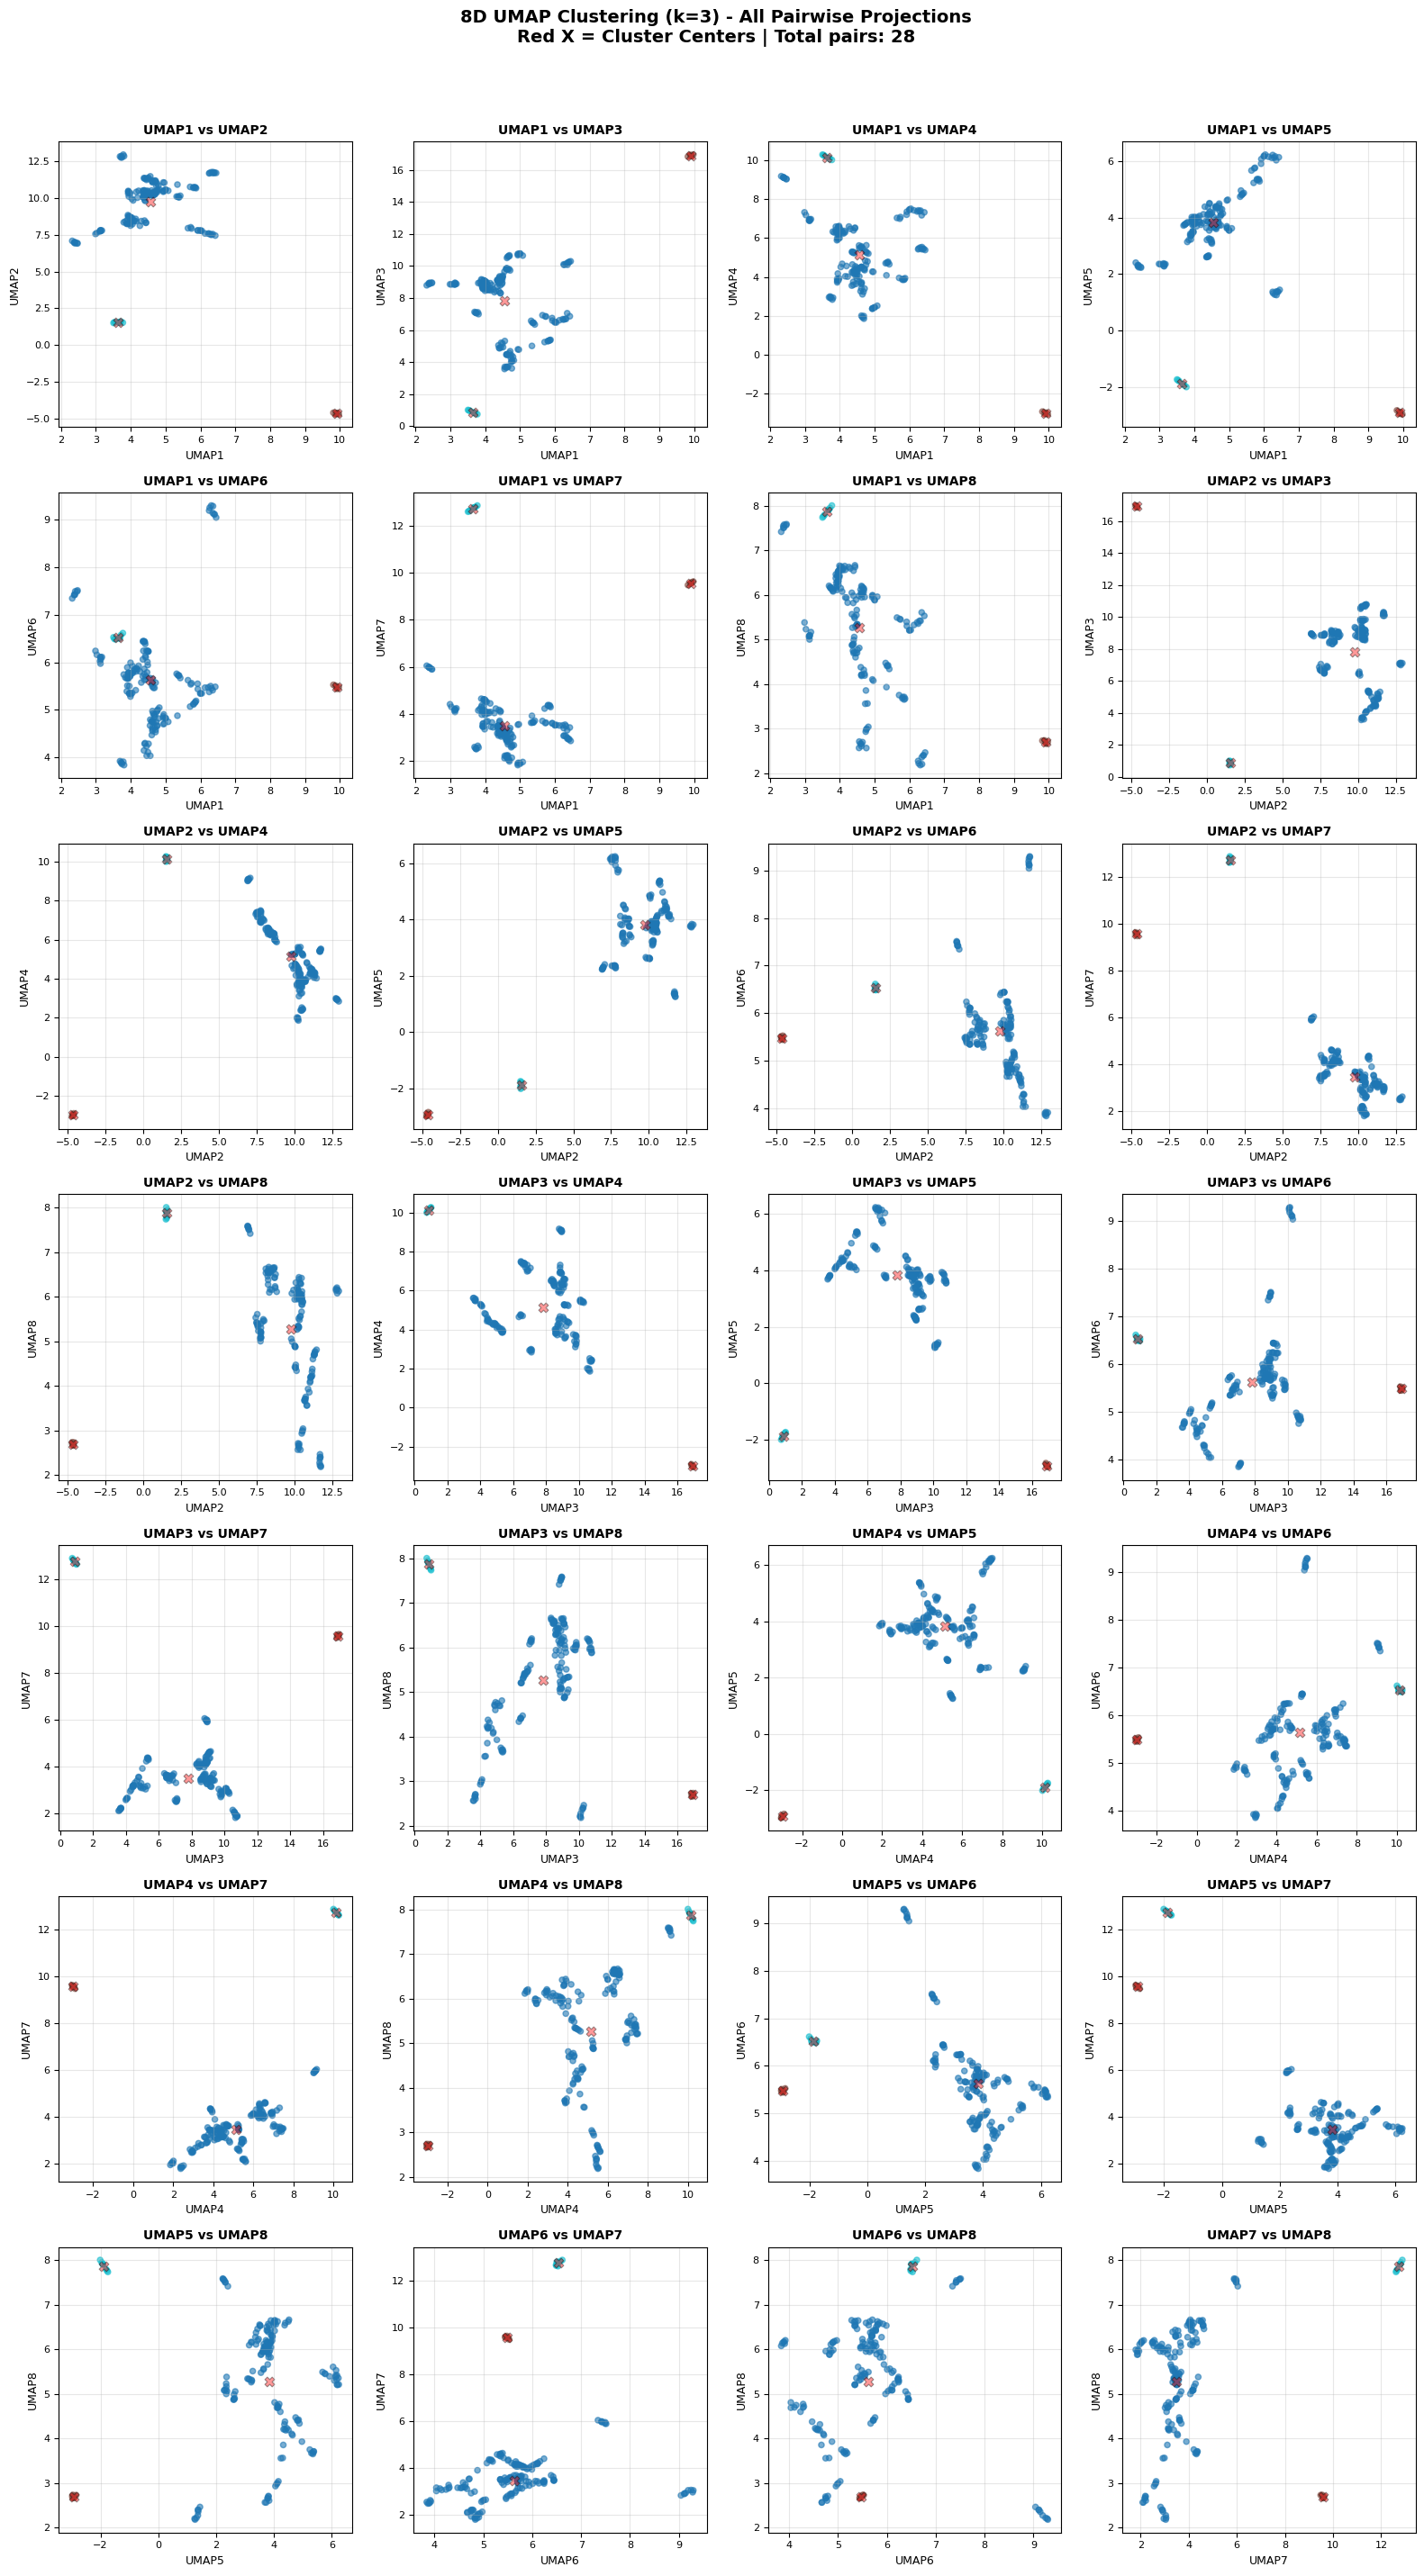


Clustering performed in 8D space
Showing all 28 pairwise projections


In [9]:
# Apply UMAP with optimized parameters
import itertools
start_time = time.time()

reducer = umap.UMAP(
    n_neighbors=best_params['n_neighbors'],
    min_dist=best_params['min_dist'],
    n_components=best_params['n_components'],
    metric=best_params['metric'],
    random_state=RANDOM_STATE
)
embedding = reducer.fit_transform(X_scaled)

# Apply KMeans with optimized number of clusters
k = best_params['n_clusters']
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(embedding)

final_runtime = time.time() - start_time
time_per_sample_ms = (final_runtime / len(embedding)) * 1000

# Store cluster labels
umap_columns = [f'UMAP{i+1}' for i in range(embedding.shape[1])]
umap_df = pd.DataFrame(embedding, columns=umap_columns)
umap_df['cluster'] = labels

# Create pairwise scatter plots for ALL UMAP dimensions
n_components = best_params['n_components']
pairs = list(itertools.combinations(range(n_components), 2))
n_pairs = len(pairs)

# Calculate grid size
cols = 4
rows = (n_pairs + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
axes = axes.flatten() if n_pairs > 1 else [axes]

# Plot each dimension pair
for idx, (i, j) in enumerate(pairs):
    ax = axes[idx]
    scatter = ax.scatter(embedding[:, i], embedding[:, j], 
                         c=labels, cmap='tab10', s=20, alpha=0.6)
    
    # Plot cluster centers for this dimension pair (smaller and lighter)
    centers = kmeans.cluster_centers_
    ax.scatter(centers[:, i], centers[:, j], c='red', s=60, alpha=0.4, 
               marker='X', edgecolors='black', linewidths=0.8)
    
    ax.set_xlabel(f'UMAP{i+1}', fontsize=9)
    ax.set_ylabel(f'UMAP{j+1}', fontsize=9)
    ax.set_title(f'UMAP{i+1} vs UMAP{j+1}', fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=8)

# Hide empty subplots
for idx in range(len(pairs), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle(f'{n_components}D UMAP Clustering (k={k}) - All Pairwise Projections\n'
             f'Red X = Cluster Centers | Total pairs: {n_pairs}', 
             fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"Clustering performed in {n_components}D space")
print(f"Showing all {n_pairs} pairwise projections")
print(f"{'='*60}")

2D Projection Rankings (by cluster separation):
--------------------------------------------------
  1. UMAP2 vs UMAP7: Silhouette = 0.8448 ← BEST
  2. UMAP1 vs UMAP7: Silhouette = 0.8243
  3. UMAP5 vs UMAP7: Silhouette = 0.8216
  4. UMAP2 vs UMAP5: Silhouette = 0.7925
  5. UMAP4 vs UMAP7: Silhouette = 0.7818


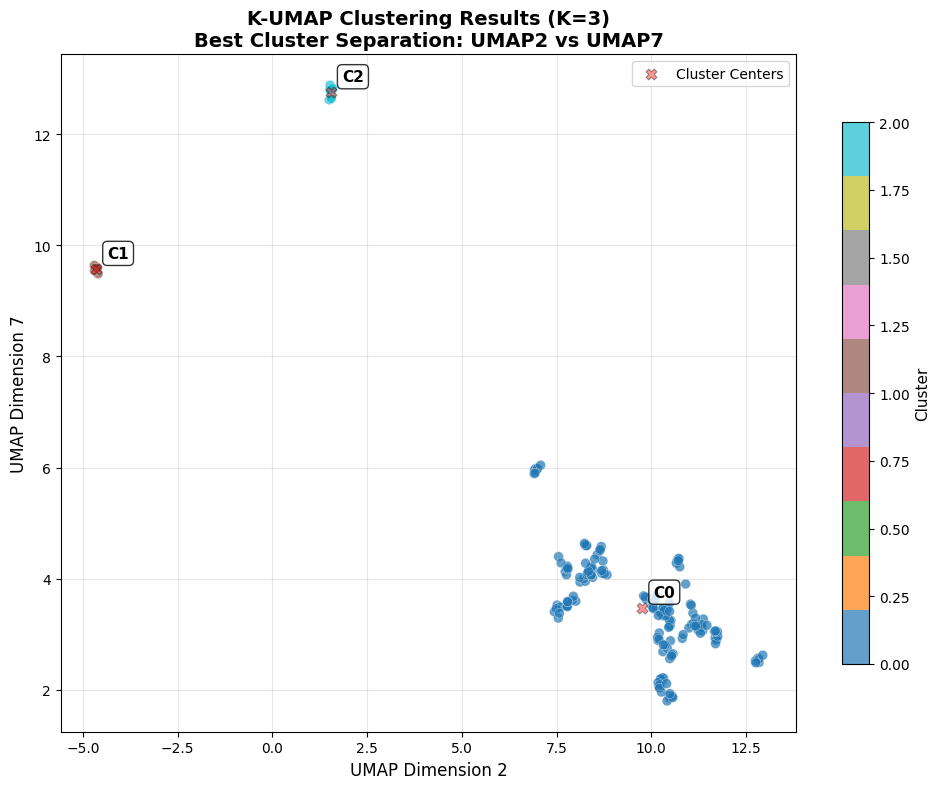


VISUALIZATION SUMMARY (Objective 1.3)
• Clustering performed in: 8D UMAP space
• Full 8D Silhouette: 0.7249


In [10]:
# Find dimension pair with BEST CLUSTER SEPARATION (Objective 1.3)
import itertools

n_components = best_params['n_components']
pairs = list(itertools.combinations(range(n_components), 2))

# Calculate silhouette score for each 2D projection
pair_scores = []
for (i, j) in pairs:
    emb_2d = embedding[:, [i, j]]
    sil_2d = silhouette_score(emb_2d, labels)
    pair_scores.append(((i, j), sil_2d))

# Sort by silhouette score (descending)
pair_scores.sort(key=lambda x: x[1], reverse=True)

# Get best pair
best_pair, best_sil_2d = pair_scores[0]
best_dim1, best_dim2 = best_pair

print(f"2D Projection Rankings (by cluster separation):")
print("-"*50)
for rank, ((i, j), sil) in enumerate(pair_scores[:5], 1):
    marker = " ← BEST" if rank == 1 else ""
    print(f"  {rank}. UMAP{i+1} vs UMAP{j+1}: Silhouette = {sil:.4f}{marker}")

# Create single paper-ready scatter plot
fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(embedding[:, best_dim1], embedding[:, best_dim2],
                     c=labels, cmap='tab10', s=50, alpha=0.7,
                     edgecolors='white', linewidth=0.3)

# Plot cluster centers (smaller and lighter)
centers = kmeans.cluster_centers_
ax.scatter(centers[:, best_dim1], centers[:, best_dim2], c='red', s=60,
           marker='X', edgecolors='black', linewidths=0.8, alpha=0.4,
           label='Cluster Centers', zorder=5)

# Add cluster labels near centers
for cluster_id in range(k):
    ax.annotate(f'C{cluster_id}', 
                (centers[cluster_id, best_dim1], centers[cluster_id, best_dim2]),
                fontsize=11, fontweight='bold',
                xytext=(8, 8), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax.set_xlabel(f'UMAP Dimension {best_dim1+1}', fontsize=12)
ax.set_ylabel(f'UMAP Dimension {best_dim2+1}', fontsize=12)
ax.set_title(f'K-UMAP Clustering Results (K={k})\n'
             f'Best Cluster Separation: UMAP{best_dim1+1} vs UMAP{best_dim2+1}',
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar.set_label('Cluster', fontsize=11)

plt.tight_layout()
plt.savefig('kumap_best_separation.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n{'='*60}")
print(f"VISUALIZATION SUMMARY (Objective 1.3)")
print(f"{'='*60}")
print(f"• Clustering performed in: {n_components}D UMAP space")
print(f"• Full {n_components}D Silhouette: {silhouette_score(embedding, labels):.4f}")
print(f"{'='*60}")

In [11]:
# Evaluate clustering quality using all UMAP components
silhouette = silhouette_score(embedding, labels)
db_index = davies_bouldin_score(embedding, labels)

print("Clustering Quality:")
print(f"• Silhouette Score: {silhouette:.4f}  (↑ better)")
print(f"• Davies-Bouldin Index: {db_index:.4f}  (↓ better)")

# Cluster size breakdown
sizes = umap_df['cluster'].value_counts().sort_index()
print("\nCluster Distribution:")
for cluster, count in sizes.items():
    pct = (count / len(umap_df)) * 100
    print(f"• Cluster {cluster}: {count} samples ({pct:.1f}%)")


Clustering Quality:
• Silhouette Score: 0.7249  (↑ better)
• Davies-Bouldin Index: 0.2099  (↓ better)

Cluster Distribution:
• Cluster 0: 169 samples (91.8%)
• Cluster 1: 7 samples (3.8%)
• Cluster 2: 8 samples (4.3%)


In [12]:
# Silhouette score per cluster
from sklearn.metrics import silhouette_samples

sample_sil = silhouette_samples(embedding, labels)
cluster_silhouette = {}
for cluster_id in np.unique(labels):
    mask = labels == cluster_id
    cluster_silhouette[int(cluster_id)] = float(sample_sil[mask].mean()) if mask.any() else float("nan")

print("Silhouette score by cluster (higher = better separation):")
for cid, score in sorted(cluster_silhouette.items()):
    print(f"• Cluster {cid}: {score:.4f}")
print(f"Overall silhouette (all clusters): {silhouette:.4f}")

Silhouette score by cluster (higher = better separation):
• Cluster 0: 0.7016
• Cluster 1: 0.9931
• Cluster 2: 0.9826
Overall silhouette (all clusters): 0.7249


In [17]:
# Compare unweighted vs weighted silhouette mean
sizes = pd.Series(labels).value_counts().sort_index()
unweighted_mean = np.mean(list(cluster_silhouette.values()))
weighted_mean = sum(cluster_silhouette[c] * sizes[c] for c in cluster_silhouette) / sizes.sum()
print("Unweighted cluster-mean silhouette:", f"{unweighted_mean:.4f}")
print("Weighted (per-sample) silhouette:", f"{weighted_mean:.4f}")
print("Overall silhouette_score():", f"{silhouette:.4f}")

Unweighted cluster-mean silhouette: 0.8924
Weighted (per-sample) silhouette: 0.7249
Overall silhouette_score(): 0.7249


In [13]:
# Analyze cluster profiles to understand feature differences
clustered = df_clean.copy()
clustered["cluster"] = labels

cluster_profiles = clustered.groupby("cluster").mean(numeric_only=True)

# Get all available numeric columns (already frequency encoded)
available_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

# Calculate variance across clusters to find most differentiating features
cluster_variance = cluster_profiles.var(axis=0).sort_values(ascending=False)

# Select top 20 most varying features (most important for differentiation)
key_cols = cluster_variance.head(20).index.tolist()

print("Cluster profiles (top 20 most differentiating features, rounded):")
print(cluster_profiles[key_cols].round(2))

# Show what features vary the most
print("\n" + "="*80)
print("FEATURE IMPORTANCE (Variance across clusters):")
print("-"*80)
for i, (feat, var) in enumerate(cluster_variance.head(20).items(), 1):
    print(f"{i:2d}. {feat:40s} → variance: {var:.4f}")

# Compare each cluster with cluster 0 (baseline)
print("\n" + "="*80)
print("CLUSTER COMPARISONS (vs Cluster 0 baseline):")
print("="*80)
for cluster_id in cluster_profiles.index:
    if cluster_id == 0:
        continue
    mean_gaps = (cluster_profiles.loc[cluster_id] - cluster_profiles.loc[0]).sort_values(key=np.abs, ascending=False)
    print(f"\n🔍 Cluster {cluster_id} - Top 15 differentiating features:")
    print("-"*80)
    for feat, gap in mean_gaps.head(15).items():
        direction = "↑" if gap > 0 else "↓"
        print(f"  {feat:40s} {direction} {gap:+.3f}")
    print("-"*60)

Cluster profiles (top 20 most differentiating features, rounded):
            bmi  has_fever  is_female  has_respiratory_issue  has_pain  \
cluster                                                                  
0       42.7600     0.6300     0.4600                 0.4900    0.4000   
1       23.4300     0.0000     0.0000                 0.0000    0.0000   
2       20.8300     1.0000     1.0000                 1.0000    0.0000   

         age_years  has_allergy  year_level  age_group  is_uti  
cluster                                                         
0          18.5100       0.2500      1.2800     0.5700  0.0400  
1          18.7100       0.0000      1.0300     0.7300  0.0000  
2          18.3800       0.0000      1.0200     0.7300  0.0000  

FEATURE IMPORTANCE (Variance across clusters):
--------------------------------------------------------------------------------
 1. bmi                                      → variance: 143.5582
 2. has_fever                              

In [14]:
# Final metrics summary
total_runtime = final_runtime  # Use the total optimization time if that's what you want to report
time_per_sample_ms = (total_runtime / len(embedding)) * 1000

from scipy.spatial.distance import cdist

# Calculate centroid distances
centers = kmeans.cluster_centers_
centroid_distances = cdist(centers, centers)
# Ignore zero distances (distance of a center to itself)
nonzero_distances = centroid_distances[centroid_distances != 0]
min_centroid_separation = nonzero_distances.min()
mean_centroid_distance = nonzero_distances.mean()


print("FINAL RESULTS SUMMARY")
print(f"Clusters: {k}")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Centroid Separation (min): {min_centroid_separation:.4f}")
print(f"Mean Centroid Distance: {mean_centroid_distance:.4f}")
print(f"Operational Runtime (UMAP + K‑Means): {total_runtime:.4f} seconds")
print(f"Time per Sample: {time_per_sample_ms:.4f} ms")
print(f"Throughput: {1000/time_per_sample_ms:.2f} samples/sec")


FINAL RESULTS SUMMARY
Clusters: 3
Silhouette Score: 0.7249
Davies-Bouldin Index: 0.2099
Centroid Separation (min): 16.3555
Mean Centroid Distance: 20.5052
Operational Runtime (UMAP + K‑Means): 0.2185 seconds
Time per Sample: 1.1873 ms
Throughput: 842.23 samples/sec


In [15]:
# Export Visualization Artifacts (matching train.py output)
import json
from datetime import datetime
from pathlib import Path

# Reload original dataframe for full patient info
original_df = pd.read_csv(r"data\final_real.csv")

# Find best 2D projection
from itertools import combinations

n_components = best_params['n_components']
pairs = list(combinations(range(n_components), 2))
pair_scores = []
for (i, j) in pairs:
    emb_2d = embedding[:, [i, j]]
    sil_2d = silhouette_score(emb_2d, labels)
    pair_scores.append(((i, j), sil_2d))

pair_scores.sort(key=lambda x: x[1], reverse=True)
best_pair, best_2d_score = pair_scores[0]
best_dim1, best_dim2 = best_pair

# Create visualization dataframe
viz_df = original_df.reset_index(drop=True).copy()
viz_df["cluster"] = labels.astype(int)

# Store ALL UMAP components
for i in range(n_components):
    viz_df[f"umap_{i+1}"] = embedding[:, i].astype(float)

# Best projection for backward compatibility
viz_df["umap_x"] = embedding[:, best_dim1].astype(float)
viz_df["umap_y"] = embedding[:, best_dim2].astype(float)
viz_df["best_projection_dims"] = f"{best_dim1+1},{best_dim2+1}"

# Patient IDs
patient_ids = None
if "Student_No" in viz_df.columns:
    patient_ids = viz_df["Student_No"].astype(str).str.strip().replace({"nan": "", "None": ""})
if patient_ids is None:
    patient_ids = pd.Series(["" for _ in range(len(viz_df))])
missing_mask = patient_ids.eq("")
patient_ids.loc[missing_mask] = (viz_df.index[missing_mask] + 1).astype(str)
viz_df["patient_id"] = patient_ids

# Display name
if {"First_Name", "Last_Name"}.issubset(viz_df.columns):
    viz_df["display_name"] = (
        viz_df["First_Name"].fillna("").astype(str).str.strip() + " " +
        viz_df["Last_Name"].fillna("").astype(str).str.strip()
    ).str.strip()

# Cluster confidence
distances = kmeans.transform(embedding)
inv_dist = 1.0 / (distances + 1e-9)
confidence = inv_dist / inv_dist.sum(axis=1, keepdims=True)
viz_df["cluster_confidence"] = confidence[np.arange(len(labels)), labels]

# Risk labels
risk_labels = {0: "Low Risk", 1: "Moderate Risk", 2: "High Risk"}
viz_df["risk_label"] = viz_df["cluster"].map(lambda c: risk_labels.get(int(c), f"Cluster {c}"))

# Create summary
summary = {
    "generated_at": datetime.utcnow().isoformat() + "Z",
    "total_patients": int(len(viz_df)),
    "n_umap_components": n_components,
    "best_2d_projection": {
        "dimensions": [best_dim1 + 1, best_dim2 + 1],
        "silhouette_2d": round(best_2d_score, 4),
    },
    "clusters": [],
}

total = len(viz_df)
numeric_cols = viz_df.select_dtypes(include=[np.number]).columns
for cluster_id, group in viz_df.groupby("cluster"):
    cluster_item = {
        "cluster": int(cluster_id),
        "count": int(len(group)),
        "percentage": round((len(group) / total) * 100, 2),
    }
    if "bmi" in group.columns:
        cluster_item["mean_bmi"] = round(pd.to_numeric(group["bmi"], errors="coerce").mean(skipna=True), 2)
    if "age_years" in group.columns:
        cluster_item["mean_age"] = round(pd.to_numeric(group["age_years"], errors="coerce").mean(skipna=True), 2)
    for col in numeric_cols:
        if col.startswith("umap_") or col in ("cluster", "umap_x", "umap_y"):
            continue
        values = pd.to_numeric(group[col], errors="coerce")
        if values.notna().any():
            cluster_item.setdefault("feature_means", {})[col] = round(float(values.mean()), 4)
    summary["clusters"].append(cluster_item)
summary["clusters"].sort(key=lambda item: item["cluster"])

# Save artifacts
artifact_dir = Path("artifacts")
artifact_dir.mkdir(parents=True, exist_ok=True)

viz_json_path = artifact_dir / "cluster_visualization.json"
viz_csv_path = artifact_dir / "cluster_visualization.csv"
summary_path = artifact_dir / "cluster_summary.json"

viz_records = json.loads(viz_df.to_json(orient="records", date_format="iso"))
with open(viz_json_path, "w", encoding="utf-8") as fh:
    json.dump(viz_records, fh, indent=2)
viz_df.to_csv(viz_csv_path, index=False)
with open(summary_path, "w", encoding="utf-8") as fh:
    json.dump(summary, fh, indent=2)

print("="*60)
print("VISUALIZATION ARTIFACTS EXPORTED")
print("="*60)
print(f"• Total records: {len(viz_records)}")
print(f"• UMAP components: {n_components}")
print(f"• Best 2D projection: UMAP{best_dim1+1} vs UMAP{best_dim2+1} (silhouette={best_2d_score:.4f})")
print(f"• Files saved to: {artifact_dir}")
print(f"  - {viz_json_path.name}")
print(f"  - {viz_csv_path.name}")  
print(f"  - {summary_path.name}")
print("="*60)

VISUALIZATION ARTIFACTS EXPORTED
• Total records: 184
• UMAP components: 8
• Best 2D projection: UMAP2 vs UMAP7 (silhouette=0.8448)
• Files saved to: artifacts
  - cluster_visualization.json
  - cluster_visualization.csv
  - cluster_summary.json


In [16]:
# Save Trained Models & Metadata (matching train.py artifacts)
import joblib

# Save models
joblib.dump(reducer, artifact_dir / "umap_reducer.joblib")
joblib.dump(kmeans, artifact_dir / "kmeans_model.joblib")
joblib.dump(imputer, artifact_dir / "knn_imputer.joblib")
joblib.dump(scaler, artifact_dir / "scaler.joblib")
joblib.dump(freq_encoding_maps, artifact_dir / "frequency_encoding_maps.joblib")

# Build training metadata
training_metadata = {
    "dataset_path": r"data\final_real.csv",
    "random_state": RANDOM_STATE,
    "optuna_trials": 50,
    "best_params": best_params,
    "prep_report": stats,
    "dropped_columns": high_card_cols if 'high_card_cols' in dir() else [],
    "encoded_columns": encoded_columns,
    "numeric_columns": num_cols,
    "metrics": {
        "silhouette": float(silhouette),
        "davies_bouldin": float(db_index),
        "cluster_sizes": {int(idx): int(count) for idx, count in enumerate(np.bincount(labels))},
        "runtime_sec": float(total_runtime),
        "time_per_sample_ms": float(time_per_sample_ms),
        "throughput_samples_per_sec": float(len(embedding) / total_runtime) if total_runtime else 0.0,
        "min_centroid_separation": float(min_centroid_separation),
        "mean_centroid_distance": float(mean_centroid_distance),
    },
    "cluster_summary": summary,
    "visualization_artifacts": {
        "visualization_json": "cluster_visualization.json",
        "visualization_csv": "cluster_visualization.csv",
        "summary_json": "cluster_summary.json",
    },
}

with open(artifact_dir / "training_metadata.json", "w", encoding="utf-8") as fh:
    json.dump(training_metadata, fh, indent=2, default=str)

print("="*60)
print("TRAINED MODELS & METADATA SAVED")
print("="*60)
print(f"• umap_reducer.joblib")
print(f"• kmeans_model.joblib")
print(f"• knn_imputer.joblib")
print(f"• scaler.joblib")
print(f"• frequency_encoding_maps.joblib")
print(f"• training_metadata.json")
print("="*60)

TRAINED MODELS & METADATA SAVED
• umap_reducer.joblib
• kmeans_model.joblib
• knn_imputer.joblib
• scaler.joblib
• frequency_encoding_maps.joblib
• training_metadata.json
